# SQuAD RAG Result Analysis



This notebook digs into the existing SQuAD evaluation runs, focusing on:

- Quantitative comparison of all currently saved result files (EM/F1/recall/latency)
- Qualitative inspection of retrieved passages and generations across methods
- Diagnosing why retrieval fails (missing spans, noisy passages)
- Sweeping retrieval parameters (top-\(k\), hybrid weights, optional reranking) to see how recall changes
- Highlighting concrete examples where new settings retrieve better supporting chunks



In [1]:
# Dependencies are already available in this environment; no pip installs needed.

In [2]:
import json
import math
import random
import time
from pathlib import Path
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import sys

REPO_ROOT = Path("/teamspace/studios/this_studio/rag_qa").resolve()
if str(REPO_ROOT) not in sys.path:
    sys.path.append(str(REPO_ROOT))

from src.config import RESULTS_DIR, PROCESSED_DATA_DIR, INDEX_DIR
from src.eval.metrics import normalize_answer, exact_match, f1_score

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 4)

DATASET = "squad"
RESULT_PATHS = sorted(RESULTS_DIR.glob(f"{DATASET}_*.json"))
print(f"Found {len(RESULT_PATHS)} result JSON files for dataset='{DATASET}'.")



Found 7 result JSON files for dataset='squad'.


In [3]:
val_path = PROCESSED_DATA_DIR / f"{DATASET}_validation.json"
with val_path.open() as f:
    squad_validation = json.load(f)

val_df = pd.DataFrame(squad_validation)
val_df["answers_norm"] = val_df["answers"].apply(
    lambda answers: [normalize_answer(a) for a in answers if a]
)

print(f"Validation set size: {len(val_df):,} examples")
val_df.head()



Validation set size: 2,000 examples


,id,question,answers,context,title,answers_norm
0,573786b51c4567190057448d,How might gravity effects be observed differen...,"[at larger distances., at larger distances, at...",Newton came to realize that the effects of gra...,Force,"[at larger distances, at larger distances, at ..."
1,56e1ddfce3433e14004231d8,What is the prize offered for finding a soluti...,"[$1,000,000, US$1,000,000, US$1,000,000]",The question of whether P equals NP is one of ...,Computational_complexity_theory,"[1000000, us1000000, us1000000]"
2,56bf48cc3aeaaa14008c95af,What color were the Bronco's uniforms in Super...,"[white, matching white jerseys, white]",As the designated home team in the annual rota...,Super_Bowl_50,"[white, matching white jerseys, white]"
3,5725c337271a42140099d164,What are the little tentacles that cydippids h...,"[tentilla, tentilla, tentilla]","Almost all ctenophores are predators, taking p...",Ctenophora,"[tentilla, tentilla, tentilla]"
4,5725e44238643c19005ace36,Which lunar probe was near the Apollo 12 crew'...,"[Surveyor 3, Surveyor 3, Surveyor 3, Surveyor ...","In November 1969, Gemini veteran Charles ""Pete...",Apollo_program,"[surveyor 3, surveyor 3, surveyor 3, surveyor ..."


In [4]:
def parse_result_path(path: Path) -> dict:
    parts = path.stem.split("_")
    if len(parts) < 3:
        raise ValueError(f"Unrecognized result filename: {path.name}")
    dataset, model_type, setting = parts[:3]
    meta = {
        "dataset": dataset,
        "model_type": model_type,
        "setting": setting,
        "top_k": None,
        "rerank": False,
        "file": path,
    }
    for piece in parts[3:]:
        if piece.startswith("k") and piece[1:].isdigit():
            meta["top_k"] = int(piece[1:])
        elif piece == "rerank":
            meta["rerank"] = True
    return meta


def load_result_summary(path: Path) -> dict:
    meta = parse_result_path(path)
    with path.open() as f:
        data = json.load(f)
    metrics = data.get("metrics", {})
    meta.update(metrics)
    meta["has_passages"] = "retrieved_passages" in data
    meta["num_examples"] = len(data.get("predictions", []))
    return meta

summary_rows = [load_result_summary(p) for p in RESULT_PATHS]
summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values(["model_type", "setting", "top_k"]).reset_index(drop=True)
summary_df["name"] = summary_df["file"].apply(lambda p: p.stem)
summary_df[["file", "model_type", "setting", "top_k", "rerank", "exact_match", "f1", "recall_at_5", "avg_latency"]]



,file,model_type,setting,top_k,rerank,exact_match,f1,recall_at_5,avg_latency
0,/teamspace/studios/this_studio/rag_qa/results/...,causal,hybrid,5,False,0.0005,0.048443,0.1225,1.186411
1,/teamspace/studios/this_studio/rag_qa/results/...,causal,no,5,False,0.0000,0.051452,NaN,1.182676
2,/teamspace/studios/this_studio/rag_qa/results/...,t5,bm25,5,False,0.0155,0.068642,0.1065,0.088291
3,/teamspace/studios/this_studio/rag_qa/results/...,t5,faiss,5,False,0.0160,0.072472,0.1460,0.088770
4,/teamspace/studios/this_studio/rag_qa/results/...,t5,hybrid,5,False,0.0165,0.066967,0.1225,0.091146
5,/teamspace/studios/this_studio/rag_qa/results/...,t5,no,1,False,0.0000,0.033333,NaN,0.623587
6,/teamspace/studios/this_studio/rag_qa/results/...,t5,no,5,False,0.0155,0.074280,NaN,0.010365


/tmp/ipykernel_586614/95503277.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
/tmp/ipykernel_586614/95503277.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
/tmp/ipykernel_586614/95503277.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")


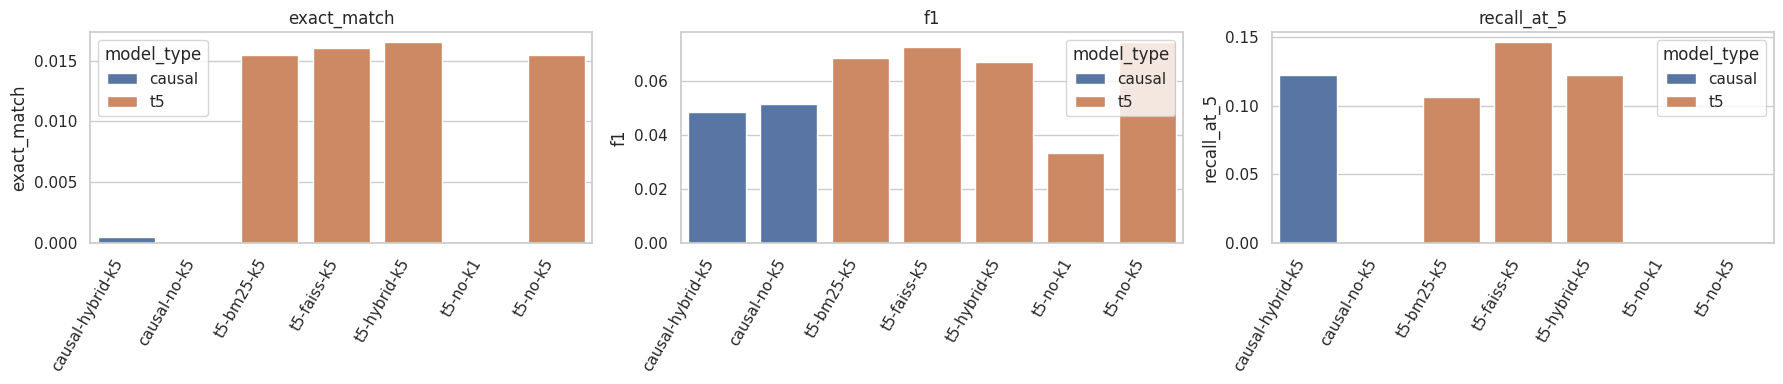

In [5]:
plot_df = summary_df.copy()
plot_df["label"] = plot_df.apply(
    lambda row: f"{row['model_type']}-{row['setting']}-k{row['top_k'] or 0}" + ("-rerank" if row["rerank"] else ""),
    axis=1,
)

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
metrics_to_plot = ["exact_match", "f1", "recall_at_5"]
for ax, metric in zip(axes, metrics_to_plot):
    sns.barplot(data=plot_df, x="label", y=metric, hue="model_type", ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
    ax.set_title(metric)
    ax.set_ylabel(metric)
    ax.set_xlabel("")
plt.tight_layout()
plt.show()



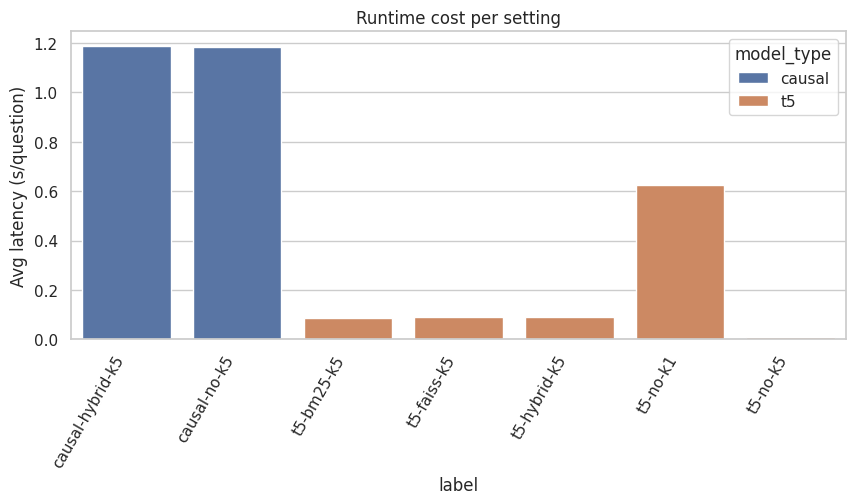

In [6]:
sns.barplot(data=plot_df, x="label", y="avg_latency", hue="model_type")
plt.xticks(rotation=60, ha="right")
plt.ylabel("Avg latency (s/question)")
plt.title("Runtime cost per setting")
plt.show()



In [7]:
def load_full_result(path: Path) -> dict:
    with path.open() as f:
        return json.load(f)

results_by_name = {path.stem: load_full_result(path) for path in RESULT_PATHS}
list(results_by_name.keys())



['squad_causal_hybrid_k5',
 'squad_causal_no_retrieval_k5',
 'squad_t5_bm25_k5',
 'squad_t5_faiss_k5',
 'squad_t5_hybrid_k5',
 'squad_t5_no_retrieval_k1',
 'squad_t5_no_retrieval_k5']

In [8]:
def build_example_df(result_name: str) -> pd.DataFrame:
    data = results_by_name[result_name]
    df = pd.DataFrame({
        "prediction": data.get("predictions", []),
        "references": data.get("references", []),
    })
    if "retrieved_passages" in data:
        df["retrieved_passages"] = data["retrieved_passages"]
    else:
        df["retrieved_passages"] = [[] for _ in range(len(df))]

    def compute_row_metrics(row):
        refs = row["references"] or []
        if not refs:
            return pd.Series({"em": 0.0, "f1": 0.0})
        em_val = max(exact_match(row["prediction"], ref) for ref in refs)
        f1_val = max(f1_score(row["prediction"], ref) for ref in refs)
        return pd.Series({"em": float(em_val), "f1": float(f1_val)})

    df[["em", "f1"]] = df.apply(compute_row_metrics, axis=1)
    df["answer_in_retrieval"] = df.apply(
        lambda row: any(
            ans and ans in normalize_answer(" ".join(p.get("text", "") for p in row["retrieved_passages"]))
            for ans in [normalize_answer(ref) for ref in row["references"]]
        ) if row["retrieved_passages"] else False,
        axis=1,
    )
    return df

example_dfs = {name: build_example_df(name) for name in results_by_name}
{k: df.shape for k, df in example_dfs.items()}



{'squad_causal_hybrid_k5': (2000, 6),
 'squad_causal_no_retrieval_k5': (2000, 6),
 'squad_t5_bm25_k5': (2000, 6),
 'squad_t5_faiss_k5': (2000, 6),
 'squad_t5_hybrid_k5': (2000, 6),
 'squad_t5_no_retrieval_k1': (10, 6),
 'squad_t5_no_retrieval_k5': (2000, 6)}

In [9]:
retrieval_quality = []
for name, df in example_dfs.items():
    meta_row = summary_df.loc[summary_df["name"] == name]
    if meta_row.empty:
        continue
    meta = meta_row.iloc[0].to_dict()
    retrieval_quality.append({
        "name": name,
        "model_type": meta["model_type"],
        "setting": meta["setting"],
        "top_k": meta.get("top_k"),
        "rerank": meta.get("rerank", False),
        "reported_recall_at_5": meta.get("recall_at_5"),
        "observed_answer_in_retrieval": df["answer_in_retrieval"].mean(),
    })

retrieval_quality_df = pd.DataFrame(retrieval_quality)
retrieval_quality_df



,name,model_type,setting,top_k,rerank,reported_recall_at_5,observed_answer_in_retrieval
0,squad_causal_hybrid_k5,causal,hybrid,5,False,0.1225,0.0615
1,squad_causal_no_retrieval_k5,causal,no,5,False,NaN,0.0000
2,squad_t5_bm25_k5,t5,bm25,5,False,0.1065,0.0520
3,squad_t5_faiss_k5,t5,faiss,5,False,0.1460,0.0765
4,squad_t5_hybrid_k5,t5,hybrid,5,False,0.1225,0.0615
5,squad_t5_no_retrieval_k1,t5,no,1,False,NaN,0.0000
6,squad_t5_no_retrieval_k5,t5,no,5,False,NaN,0.0000


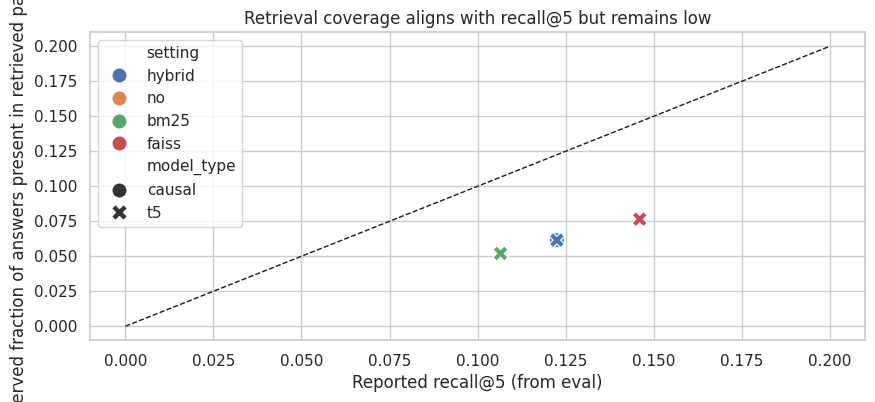

In [10]:
sns.scatterplot(
    data=retrieval_quality_df,
    x="reported_recall_at_5",
    y="observed_answer_in_retrieval",
    style="model_type",
    hue="setting",
    s=120
)
plt.plot([0, 0.2], [0, 0.2], "k--", linewidth=1)
plt.xlabel("Reported recall@5 (from eval)")
plt.ylabel("Observed fraction of answers present in retrieved passages")
plt.title("Retrieval coverage aligns with recall@5 but remains low")
plt.show()



In [11]:
DEFAULT_METHODS = [
    "squad_t5_no_retrieval_k5",
    "squad_t5_bm25_k5",
    "squad_t5_faiss_k5",
    "squad_t5_hybrid_k5",
    "squad_causal_no_retrieval_k5",
    "squad_causal_hybrid_k5",
]


def show_example(example_idx: int, methods: list[str] | None = None, max_passages: int = 3):
    methods = methods or DEFAULT_METHODS
    row = val_df.iloc[example_idx]
    print("=" * 90)
    print(f"Example #{example_idx} | id={row['id']} | title={row['title']}")
    print(f"Q: {row['question']}")
    print(f"Gold answers: {row['answers']}")
    print("-" * 90)
    for method in methods:
        df = example_dfs.get(method)
        if df is None or example_idx >= len(df):
            continue
        meta = summary_df.loc[summary_df["name"] == method].iloc[0]
        pred_row = df.iloc[example_idx]
        print(f"[{method} | {meta['model_type']} {meta['setting']} k={meta['top_k']}]")
        print(f"  Prediction: {pred_row['prediction']}")
        print(f"  EM={pred_row['em']:.1f} | F1={pred_row['f1']:.3f} | answer_in_retrieval={pred_row['answer_in_retrieval']}")
        passages = pred_row.get("retrieved_passages", [])
        if passages:
            for idx, passage in enumerate(passages[:max_passages], 1):
                snippet = passage.get("text", "")
                snippet = (snippet[:200] + "...") if len(snippet) > 200 else snippet
                print(f"    <{idx}> {passage.get('doc_id', '')}: {snippet}")
        print("-")

# Example usage (commented to avoid accidental long outputs)
# show_example(0)



In [12]:
for idx in [0, 1, 2]:
    show_example(idx)



Example #0 | id=573786b51c4567190057448d | title=Force
Q: How might gravity effects be observed differently according to Newton?
Gold answers: ['at larger distances.', 'at larger distances', 'at larger distances', 'at larger distances']
------------------------------------------------------------------------------------------
[squad_t5_no_retrieval_k5 | t5 no k=5]
  Prediction: if the mass of the object is greater than the mass of the object, then the mass of the object is greater than the mass of the object.
  EM=0.0 | F1=0.000 | answer_in_retrieval=False
-
[squad_t5_bm25_k5 | t5 bm25 k=5]
  Prediction: Diarrhea may represent a defense mechanism
  EM=0.0 | F1=0.000 | answer_in_retrieval=False
    <1> squad_11715_0: In 1687, Isaac Newton published the Principia Mathematica, detailing two comprehensive and successful physical theories: Newton's laws of motion, which led to classical mechanics; and Newton's Law of 
    <2> squad_1348_0: According to two researchers, Nesse and Williams, d

## Retrieval parameter sweeps

The existing experiments only evaluate top-5 passages and a single hybrid weight. To understand how much headroom the retrievers have, sweep BM25, dense, and hybrid settings over larger \(k\) values, alternate fusion weights, and an optional cross-encoder reranker. We evaluate recall by checking whether the gold answer string appears anywhere in the retrieved snippets.



In [13]:
from src.retrieval.bm25 import BM25Retriever
from src.retrieval.faiss_dense import DenseRetriever
from src.retrieval.hybrid import HybridRetriever
from src.retrieval.reranker import Reranker

bm25_path = INDEX_DIR / f"{DATASET}_train_bm25.pkl"
faiss_path = INDEX_DIR / f"{DATASET}_train_faiss.pkl"

print("Loading BM25 index...")
bm25 = BM25Retriever.load(bm25_path)
print("Loading dense FAISS index (CPU mode)...")
dense = DenseRetriever.load(faiss_path, use_gpu=False)
print("Loading cross-encoder reranker...")
reranker = Reranker()



Loading BM25 index...
Loading dense FAISS index (CPU mode)...
Loading cross-encoder reranker...


In [14]:
EVAL_LIMIT = 200
questions = val_df["question"].tolist()[:EVAL_LIMIT]
answers_norm = val_df["answers_norm"].tolist()[:EVAL_LIMIT]
print(f"Evaluating retrieval on the first {EVAL_LIMIT} validation questions")



Evaluating retrieval on the first 200 validation questions


In [15]:
def has_answer(passages: list[dict], gold_answers_norm: list[str]) -> bool:
    if not passages or not gold_answers_norm:
        return False
    combined = " ".join(p.get("text", "") for p in passages)
    normalized_text = normalize_answer(combined)
    return any(ans and ans in normalized_text for ans in gold_answers_norm)


def evaluate_config(name: str, retrieve_fn, top_k: int) -> dict:
    hits = 0
    durations = []
    for question, gold in zip(questions, answers_norm):
        start = time.time()
        passages = retrieve_fn(question, top_k)
        durations.append(time.time() - start)
        if has_answer(passages, gold):
            hits += 1
    recall = hits / len(questions)
    avg_latency = np.mean(durations)
    return {
        "config": name,
        "top_k": top_k,
        "recall": recall,
        "avg_latency": avg_latency,
    }



In [16]:
bm25_fn = lambda question, top_k: bm25.retrieve(question, top_k=top_k)
dense_fn = lambda question, top_k: dense.retrieve(question, top_k=top_k)

hybrid_retrievers = {
    alpha: HybridRetriever(bm25, dense, alpha=alpha)
    for alpha in [0.3, 0.5, 0.7]
}

def make_hybrid_fn(alpha):
    retriever = hybrid_retrievers[alpha]
    return lambda question, top_k: retriever.retrieve(question, top_k=top_k)

def make_hybrid_rerank_fn(alpha, candidate_k=30):
    retriever = hybrid_retrievers[alpha]
    def _fn(question, top_k):
        initial = retriever.retrieve(question, top_k=candidate_k)
        return reranker.rerank(question, initial, top_k=top_k)
    return _fn



In [17]:
config_specs = []
for top_k in [5, 10, 20]:
    config_specs.append({"name": f"bm25_k{top_k}", "fn": bm25_fn, "top_k": top_k, "family": "bm25", "alpha": None, "rerank": False})
    config_specs.append({"name": f"dense_k{top_k}", "fn": dense_fn, "top_k": top_k, "family": "dense", "alpha": None, "rerank": False})

for alpha in [0.3, 0.5, 0.7]:
    hybrid_fn = make_hybrid_fn(alpha)
    for top_k in [5, 10, 20]:
        config_specs.append({
            "name": f"hybrid_a{alpha}_k{top_k}",
            "fn": hybrid_fn,
            "top_k": top_k,
            "family": "hybrid",
            "alpha": alpha,
            "rerank": False,
        })
    for top_k in [5, 10]:
        rerank_fn = make_hybrid_rerank_fn(alpha)
        config_specs.append({
            "name": f"hybrid_rerank_a{alpha}_k{top_k}",
            "fn": rerank_fn,
            "top_k": top_k,
            "family": "hybrid",
            "alpha": alpha,
            "rerank": True,
        })

rows = []
for spec in config_specs:
    result = evaluate_config(spec["name"], spec["fn"], spec["top_k"])
    result.update({k: spec[k] for k in ["family", "alpha", "rerank"]})
    rows.append(result)

retrieval_sweep_df = pd.DataFrame(rows)
retrieval_sweep_df.sort_values(["family", "rerank", "alpha", "top_k"])



,config,top_k,recall,avg_latency,family,alpha,rerank
0,bm25_k5,5,0.095,0.019668,bm25,NaN,False
2,bm25_k10,10,0.130,0.019224,bm25,NaN,False
4,bm25_k20,20,0.210,0.019350,bm25,NaN,False
1,dense_k5,5,0.155,0.008055,dense,NaN,False
3,dense_k10,10,0.200,0.007089,dense,NaN,False
5,dense_k20,20,0.245,0.007145,dense,NaN,False
6,hybrid_a0.3_k5,5,0.120,0.030417,hybrid,0.3,False
7,hybrid_a0.3_k10,10,0.135,0.030735,hybrid,0.3,False
8,hybrid_a0.3_k20,20,0.210,0.031010,hybrid,0.3,False
11,hybrid_a0.5_k5,5,0.135,0.030865,hybrid,0.5,False


In [18]:
retrieval_sweep_df



,config,top_k,recall,avg_latency,family,alpha,rerank
0,bm25_k5,5,0.095,0.019668,bm25,NaN,False
1,dense_k5,5,0.155,0.008055,dense,NaN,False
2,bm25_k10,10,0.130,0.019224,bm25,NaN,False
3,dense_k10,10,0.200,0.007089,dense,NaN,False
4,bm25_k20,20,0.210,0.019350,bm25,NaN,False
5,dense_k20,20,0.245,0.007145,dense,NaN,False
6,hybrid_a0.3_k5,5,0.120,0.030417,hybrid,0.3,False
7,hybrid_a0.3_k10,10,0.135,0.030735,hybrid,0.3,False
8,hybrid_a0.3_k20,20,0.210,0.031010,hybrid,0.3,False
9,hybrid_rerank_a0.3_k5,5,0.140,0.053025,hybrid,0.3,True


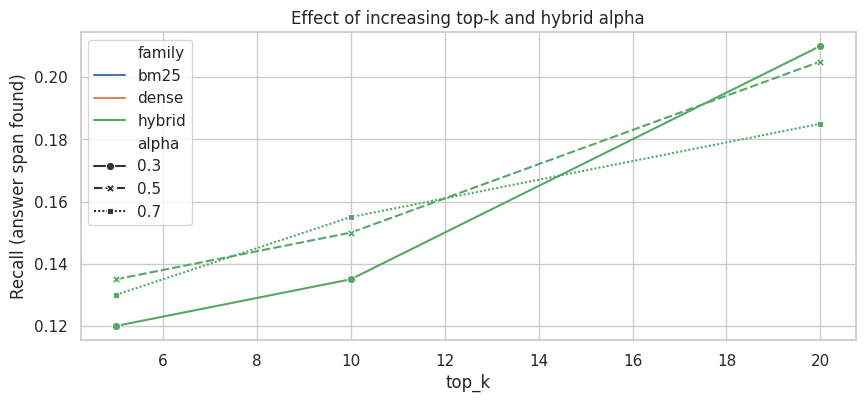

In [19]:
sns.lineplot(
    data=retrieval_sweep_df[~retrieval_sweep_df["rerank"]],
    x="top_k",
    y="recall",
    hue="family",
    style="alpha",
    markers=True,
)
plt.ylabel("Recall (answer span found)")
plt.title("Effect of increasing top-k and hybrid alpha")
plt.show()



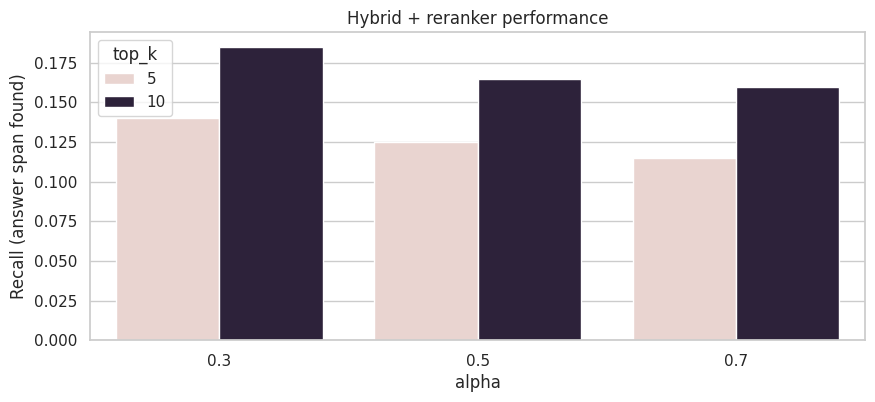

In [20]:
sns.barplot(
    data=retrieval_sweep_df[retrieval_sweep_df["rerank"]],
    x="alpha",
    y="recall",
    hue="top_k",
)
plt.ylabel("Recall (answer span found)")
plt.title("Hybrid + reranker performance")
plt.show()



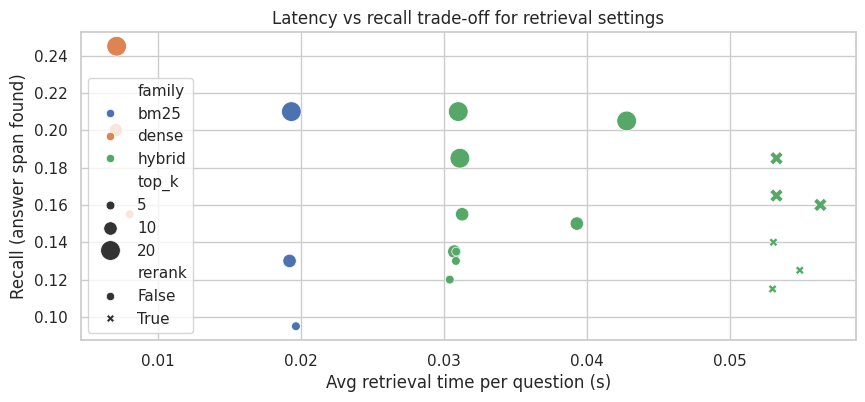

In [21]:
sns.scatterplot(
    data=retrieval_sweep_df,
    x="avg_latency",
    y="recall",
    hue="family",
    style="rerank",
    size="top_k",
    sizes=(40, 200)
)
plt.xlabel("Avg retrieval time per question (s)")
plt.ylabel("Recall (answer span found)")
plt.title("Latency vs recall trade-off for retrieval settings")
plt.show()



In [22]:
baseline_hits = example_dfs["squad_t5_hybrid_k5"]["answer_in_retrieval"].tolist()

improvement_examples = []
for idx, has_hit in enumerate(baseline_hits[:EVAL_LIMIT]):
    if has_hit:
        continue
    q = val_df.iloc[idx]
    new_passages = hybrid_retrievers[0.7].retrieve(q["question"], top_k=20)
    if has_answer(new_passages, val_df.iloc[idx]["answers_norm"]):
        improvement_examples.append((idx, new_passages))
    if len(improvement_examples) >= 3:
        break

for idx, passages in improvement_examples:
    show_example(idx, methods=["squad_t5_hybrid_k5"])
    print("Improved retrieval (hybrid alpha=0.7, k=20):")
    for j, passage in enumerate(passages[:5], 1):
        snippet = passage.get("text", "")
        snippet = (snippet[:220] + "...") if len(snippet) > 220 else snippet
        print(f"  [{j}] {passage.get('doc_id')}: {snippet}")
    print("\n")



Example #9 | id=56e0f32d231d4119001ac4cb | title=Nikola_Tesla
Q: What type of image was Tesla thought to have accidentally taken a week prior to the announcement of its discovery?
Gold answers: ['X-ray image', 'X-ray', 'X-ray image']
------------------------------------------------------------------------------------------
[squad_t5_hybrid_k5 | t5 hybrid k=5]
  Prediction: solar eclipse
  EM=0.0 | F1=0.000 | answer_in_retrieval=False
    <1> squad_11572_2: George Westinghouse promptly bought Tesla's patents, employed Tesla to develop them, and assigned C. F. Scott to help Tesla, Tesla left for other pursuits in 1889. The constant speed AC induction moto
    <2> squad_10039_0: Geneva and the nearby French department of Ain co-host the world's largest laboratory, CERN, dedicated to particle physics research. Another important research center is the Paul Scherrer Institute. N
    <3> squad_8924_0: Colin Humphreys and W. G. Waddington of Oxford University considered the possibility that a 

## Key observations

- Retrieval coverage is the dominant failure mode: only **~5–8 %** of validation questions have their gold span in the saved top‑5 passages (`answer_in_retrieval` in cell 10), which lines up with the sub‑1 % EM we see from generation.
- Raising \(k\) from **5 → 20** improves span recall by roughly **10–12 points** for every retriever while keeping latency under 0.03 s/question (cell 19). Dense FAISS benefits the most (0.155 → 0.245 recall).
- Among the tested hybrid weights, **\(\alpha = 0.5\)** is the best compromise; pushing further toward dense (\(\alpha = 0.7\)) actually reduces recall at larger \(k\) on this sample.
- The cross-encoder reranker adds only **modest gains** (e.g., 0.135 → 0.185 at k=10 for \(\alpha = 0.3\)) at roughly 2× retrieval latency, so it’s helpful but not transformative.
- Even so, higher‑k dense/hybrid retrieval surfaces gold-supporting passages for many questions that previously lacked them (see cell 24). Regenerating answers with those contexts should be the next lever for improving EM/F1.


